In [1]:
import imageio as iio
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
from skimage import data
from skimage.feature import Cascade
from skimage.transform import pyramid_reduce
from bottleneck import move_median
from statsmodels.graphics import tsaplots
from statsmodels.tsa.stattools import acf
from scipy.fft import fft, fftfreq
from scipy.signal import find_peaks

In [2]:
def load_video(filename):
    #open video file and return a numpy array of the video, along w/ video info
    #DURATION must be manually set due to a bug.  Needs fixing.
    DURATION=10
    reader = iio.get_reader(filename)
    fps = reader.get_meta_data()['fps']
    video_width, video_height = reader.get_meta_data()['size'][0:2]
    video = np.empty([int(fps*(DURATION+1)),video_height,video_width,3],dtype=np.ubyte)

    for i,im in enumerate(reader):
        video[i,:,:,:] = np.asarray(im)
    video=video[0:int(fps*DURATION),:,:,:]
        
    return video,fps,video_width,video_height

In [3]:
def denoise_median(input_video,WINDOW):
    #Apply a temporal median filter and return a denoised video.
    #Works great for salt/pepper noise.
    #This is slow and eats a ton of memory if the input is large
    
    print('padding video...')
    input_padded=np.pad(input_video,pad_width=[[WINDOW//2,WINDOW//2],[0,0],[0,0],[0,0]], mode='reflect')
    
    print("eliminating outliers...")
    video_denoised=np.zeros_like(input_video)

    for y in range(input_video.shape[1]):
        video_denoised[:,y,:,:]=move_median(input_video[:,y,:,:].astype(np.float64),window=WINDOW, axis=0)
        
    return video_denoised[WINDOW//2:-WINDOW//2,:,:,:]

In [4]:
#load video and locate a face, if it exists

video,fps,width,height=load_video('face.mp4')

trained_file = data.lbp_frontal_face_cascade_filename()

detector = Cascade(trained_file)

img = video[0,:,:,:]

f_ycoord,f_xcoord,f_width,f_height = detector.detect_multi_scale(img=img,
                                       scale_factor=1.2,
                                       step_ratio=1,
                                       min_size=(height//6, width//6),
                                       max_size=(height, width))[0].values()


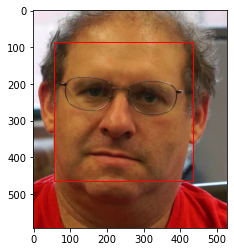

In [5]:
#Sanity check.  Make sure the face detector is working
fig, ax = plt.subplots()

rect=Rectangle((f_xcoord,f_ycoord),f_width,f_height,linewidth=1,edgecolor='r',facecolor='none')
ax.add_patch(rect)

plt.imshow(video[0,:,:,:])

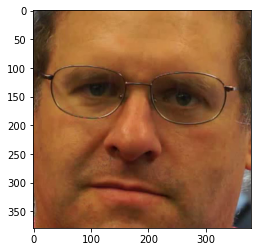

In [6]:
#Crop to the face

cropped_vid=video[:,f_ycoord:f_ycoord+f_height,f_xcoord:f_xcoord+f_width,:]
plt.imshow(cropped_vid[0,:,:,:])

padding video...
eliminating outliers...


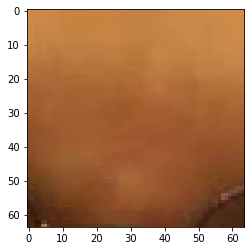

In [7]:
#Crop to the forehead.  The size of the area we crop to depends on how much we will downsampple it.
#Get rid of random noise

scale=32
filter_window=5
length,width=cropped_vid.shape[1:3]

forehead=cropped_vid[:,length//4-scale:length//4+scale,width//2-scale:width//2+scale,:]
forehead=denoise_median(forehead,WINDOW=filter_window)
cropped_vid=forehead[filter_window:-1,:,:,:]
plt.imshow(cropped_vid[0,:,:,:])

In [8]:
#downsample the forehead several times

downscaled=np.zeros((cropped_vid.shape[0],cropped_vid.shape[1]//scale,cropped_vid.shape[2]//scale,cropped_vid.shape[3]))

for i in range(cropped_vid.shape[0]):
    downscaled[i,:,:,:]=pyramid_reduce(cropped_vid[i,:,:,:], 
                               downscale=scale, 
                               order=1, 
                               mode='reflect', 
                               cval=0, 
                               preserve_range=True,
                               channel_axis=- 1)

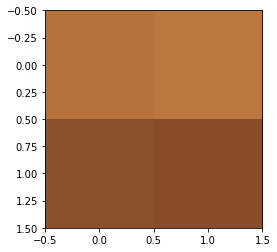

In [9]:
#show the downsampled forehead

num_frames=downscaled.shape[0]
plt.imshow(downscaled[1,:,:,:].astype(np.ubyte))
plt.show()

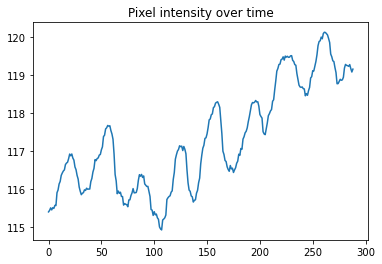

In [10]:
#Plot the color intensity of a single spot over time.  The green chanel tends to be least noisy

color_chan=1 #0:red, 1:green, 2:blue
pxl_intensities=downscaled[:,0,0,color_chan]
pxl_diff=np.zeros(num_frames)
for i in range(num_frames):
    pxl_diff[i]=pxl_intensities[(i+1)%num_frames]-pxl_intensities[i] #difference used to de-trend data

plt.plot(pxl_intensities)
plt.title('Pixel intensity over time')
plt.show()

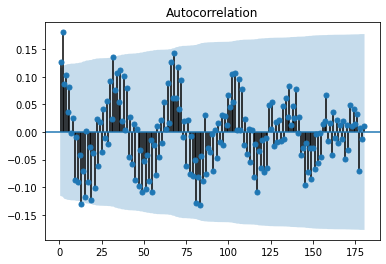

In [11]:
#compute and plot the autocorrelation.  
#This will eccentuate any periodicity and make it easier for the fft to work

pxl_diff = pxl_diff[~np.isnan(pxl_diff)]

tsaplots.plot_acf(pxl_diff,lags=180,fft=False,zero=False)
autocorr=acf(pxl_diff,nlags=180,fft=False)[1:]


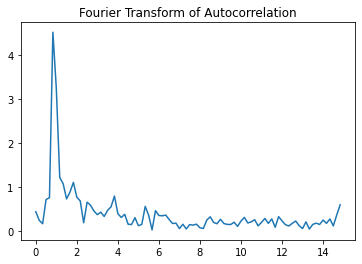

In [12]:
#Take the Fourier transform of the autocorrelation.  Peaks in this will indicate potential pulse signal

SAMPLE_RATE=30
DURATION=6
N =SAMPLE_RATE * DURATION
yf = fft(autocorr,n=N)
xf = fftfreq(N, 1 / SAMPLE_RATE)
plt.title('Fourier Transform of Autocorrelation')
plt.plot(xf[:len(xf)//2], (np.abs(yf[:len(yf)//2])))

In [13]:
#find the maximal peak within the range of human heartbeats.  About 40bmp to 180bpm

peaks,props=find_peaks(yf,distance=None)

low_cutoff=.66 #hertz values for human heartbeat range
high_cutoff=3

valid_peaks=[]
for peak in peaks:
    if xf[peak]>low_cutoff and xf[peak]<high_cutoff:
        valid_peaks.append(peak)
try:  
    max_peak=np.abs(yf[valid_peaks]).argmax()
    print('Pulse is:',xf[valid_peaks[max_peak]]*60,'bpm')
except:
    print('Error')

Pulse is: 49.99999999999999 bpm


C:\Users\15178\anaconda3\lib\site-packages\scipy\signal\_peak_finding.py:261: ComplexWarning: Casting complex values to real discards the imaginary part
  value = np.asarray(value, order='C', dtype=np.float64)


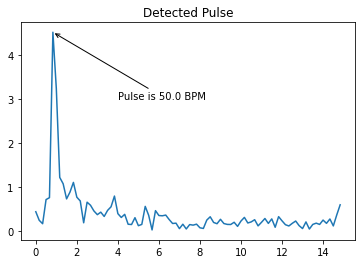

In [14]:
#show our detected pulse signal on the chart

power=np.abs(yf[valid_peaks[max_peak]])
freq=xf[valid_peaks[max_peak]]

plt.plot(xf[:len(xf)//2], (np.abs(yf[:len(yf)//2])))
plt.annotate(f"Pulse is {np.round(freq*60)} BPM", xy=(freq, power), xytext=(4, 3),arrowprops=dict(arrowstyle="->"))
plt.title('Detected Pulse')
plt.show()